In [2]:
# Loading the libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Reading the data
df = pd.read_csv("/content/drive/MyDrive/Twitter_data.csv", low_memory = False)
df = df.dropna()
print(df.head())

                 TweetID       Day   Hour  Lang  IsReshare   Reach  \
0  tw-682712873332805633  Thursday   17.0    en      False    44.0   
1  tw-682713045357998080  Thursday   17.0    en       True  1810.0   
2  tw-682713219375476736  Thursday   17.0    en      False   282.0   
3  tw-682713436967579648  Thursday   17.0    en      False  2087.0   
4  tw-682714048199311366  Thursday   17.0    en      False   953.0   

    RetweetCount   Likes   Sentiment  \
0            0.0     0.0         0.0   
1            5.0     0.0         2.0   
2            0.0     0.0         0.0   
3            4.0     0.0         0.0   
4            0.0     0.0         0.0   

                                                text   LocationID  \
0  We are hiring: Senior Software Engineer - Prot...       3751.0   
1  RT @CodeMineStatus: This is true Amazon Web Se...       3989.0   
2  Devops Engineer Aws Ansible Cassandra Mysql Ub...       3741.0   
3  Happy New Year to all those AWS instances of o...       375

In [4]:
# removing tw- string from user id and tweet id and converting it into integer
df["TweetID"] = df["TweetID"].str.replace('tw-', '').astype(np.int64)
df[" UserID"] = df[" UserID"].str.replace('tw-', '').astype(np.int64)

In [5]:
# printing the data to check if tweet id and user id column are converted or not
df = df.drop(columns = [" text"])
print(df)

                TweetID       Day   Hour  Lang  IsReshare    Reach  \
0    682712873332805633  Thursday   17.0    en      False     44.0   
1    682713045357998080  Thursday   17.0    en       True   1810.0   
2    682713219375476736  Thursday   17.0    en      False    282.0   
3    682713436967579648  Thursday   17.0    en      False   2087.0   
4    682714048199311366  Thursday   17.0    en      False    953.0   
..                  ...       ...    ...   ...        ...      ...   
994  683738642334892032    Sunday   12.0    en      False     22.0   
995  683739639107203073    Sunday   13.0    en      False     70.0   
996  683739842673520640    Sunday   13.0    en      False  17422.0   
997  683740297575051265    Sunday   13.0    en      False    710.0   
998  683741220896641025    Sunday   13.0    en       True   1691.0   

      RetweetCount   Likes   Sentiment   LocationID      UserID  
0              0.0     0.0         0.0       3751.0    40932430  
1              5.0     0.0 

In [6]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label_lang = le.fit_transform(df[' Lang'])
label_reshare = le.fit_transform(df[' IsReshare'])
label_Day = le.fit_transform(df['Day'])

df[' Lang'] = label_lang
df[' IsReshare'] = label_reshare
df['Day'] = label_Day

df = df.drop(columns = ["Day"])

for column in df.columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())    

In [7]:
# getting the chi scores 
from sklearn.feature_selection import chi2
chi_scores = chi2(df,label_Day)
print(chi_scores)

(array([1.59416818e+02, 3.76397718e+01, 2.54134132e-02, 1.66495493e+01,
       1.42524965e+00, 6.36230959e-01, 1.84151253e+00, 3.60801260e-01,
       4.99282231e-01, 7.38645801e+00]), array([2.44897257e-34, 3.36899955e-08, 9.98930688e-01, 8.34252838e-04,
       6.99626893e-01, 8.88090304e-01, 6.05943276e-01, 9.48215502e-01,
       9.19049074e-01, 6.05487345e-02]))


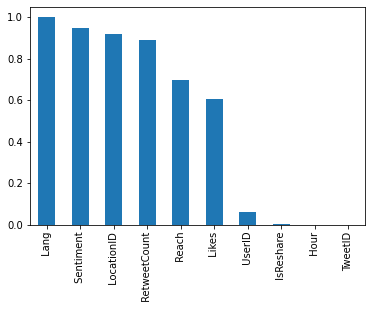

In [8]:
# Plotting the pscores
p_values = pd.Series(chi_scores[1],index = df.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [9]:
# Removed labels with high p score 
df.drop(labels=[' Lang', " Sentiment", " LocationID", " RetweetCount",' Reach', ' Likes', ], axis=1, inplace=True)

In [11]:
# Converting the data into numpy array
data = df.to_numpy()
print(data.shape)

(997, 4)


In [12]:
# Clusters stores the cluster along with data, cluster_indexes stores indices of clusters
clusters = []
cluster_indexes = []
iter = 0

# first we add all individual points into the cluster, all individual clusters are intially lists with length = 1
for i in range(data.shape[0]):
    new_list = [i]
    cluster_indexes.append(new_list)
for i in range(data.shape[0]):
    new_list = []
    new_list.append(data[i,:])
    clusters.append(new_list)

# this function is called when one of the sample is a cluster
def interclust(sample1, sample2):
    dist = []
    for i in range(len(sample1)):
        for j in range(len(sample2)):
            dist.append(np.linalg.norm(sample1[i] - sample2[j]))
    return max(dist)

# we put a while loop until total clusters > 4
while(len(clusters) > 4):
    # We make the distance matrix
    dist = np.empty((len(clusters), len(clusters)))
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            # if i == j meaning distance between same point we make it a very high value
            if(i == j):
                dist[i][j] = 10**4
            # calculate distance between other points , two cases either one of them is cluster or both are individual points
            else:
                if(len(clusters[i]) > 1 or len(clusters[j]) > 1):
                    dist[i][j] = interclust(clusters[i], clusters[j])
                else:
                    dist[i][j] = np.linalg.norm(clusters[i][0] - clusters[j][0])
    index = np.where(dist == dist.min())
    # we find the higher index and remove that first so that it doesnt change the index of the other element which is to be removed
    if(index[0][0] > index[1][0]):
        x,y = index[0][0], index[1][0]
    else:
        y,x = index[0][0], index[1][0]
    sample1 = clusters[x]
    sample2 = clusters[y]
    index1 = cluster_indexes[x]
    index2 = cluster_indexes[y]
    clusters.pop(x)
    clusters.pop(y)
    cluster_indexes.pop(x)
    cluster_indexes.pop(y)
    final_index = index1 + index2
    final = sample1 + sample2

    # we add the final new cluster
    clusters.append(final)
    cluster_indexes.append(final_index)  

    # we print the iteration and current number of clusters
    print("Iteration %d done"%(iter+1))
    print("Number of clusters present = %d"%(len(clusters)))
    iter+=1

print(clusters)      

Iteration 1 done
Number of clusters present = 996
Iteration 2 done
Number of clusters present = 995
Iteration 3 done
Number of clusters present = 994
Iteration 4 done
Number of clusters present = 993
Iteration 5 done
Number of clusters present = 992
Iteration 6 done
Number of clusters present = 991
Iteration 7 done
Number of clusters present = 990
Iteration 8 done
Number of clusters present = 989
Iteration 9 done
Number of clusters present = 988
Iteration 10 done
Number of clusters present = 987
Iteration 11 done
Number of clusters present = 986
Iteration 12 done
Number of clusters present = 985
Iteration 13 done
Number of clusters present = 984
Iteration 14 done
Number of clusters present = 983
Iteration 15 done
Number of clusters present = 982
Iteration 16 done
Number of clusters present = 981
Iteration 17 done
Number of clusters present = 980
Iteration 18 done
Number of clusters present = 979
Iteration 19 done
Number of clusters present = 978
Iteration 20 done
Number of clusters pre

In [13]:
# Made a copy of the cluster data 
cluster_complete = clusters.copy()
cluster_complete_index = cluster_indexes.copy()
print(cluster_indexes)

[[61, 57, 71, 59, 51, 84, 80, 89, 41, 37, 35, 27, 25, 24, 33, 19, 18, 10, 17, 63, 52, 81, 9, 348, 329, 277, 273, 275, 287, 282, 295, 292, 307, 298, 293, 303, 381, 363, 401, 372, 364, 328, 327, 786, 785, 765, 790, 787, 783, 782, 773, 768, 776, 771, 759, 756, 754, 733, 726, 728, 727, 731, 749, 748, 747, 746, 744, 750, 716, 737, 464, 462, 472, 470, 452, 448, 455, 422, 419, 435, 703, 695, 676, 669, 732, 723, 671, 709, 706, 683, 781, 772, 760, 753, 651, 639, 588, 626, 371, 349, 324, 317, 369, 443, 441, 453, 445, 45, 1, 54, 53, 58, 82], [493, 490, 499, 498, 486, 479, 487, 481, 474, 501, 494, 511, 510, 509, 521, 518, 513, 512, 514, 508, 517, 507, 506, 539, 531, 537, 532, 527, 520, 530, 544, 540, 533, 528, 525, 519, 147, 136, 159, 153, 156, 170, 168, 172, 132, 127, 134, 138, 137, 141, 130, 126, 145, 144, 151, 106, 102, 94, 111, 119, 116, 117, 122, 121, 118, 112, 91, 196, 188, 205, 191, 220, 215, 213, 223, 222, 218, 184, 181, 182, 187, 186, 189, 192, 245, 242, 241, 234, 228, 225, 235, 232, 229,

In [14]:
# Deciding label of class
res = [0,0,0,0]
for i in range(len(cluster_complete_index)):
    a = [0,0,0,0]
    for j in range(len(cluster_complete_index[i])):
        a[label_Day[cluster_complete_index[i][j]]]+=1
    
    res[i] = a.index(max(a))

# Getting the accuracy
acc = 0
for i in range(len(cluster_complete_index)):
    for j in range(len(cluster_complete_index[i])):
        if(res[i] == label_Day[cluster_complete_index[i][j]]):
            acc+=1

acc = (acc*100.000)/997.00
print(acc)

42.42728184553661


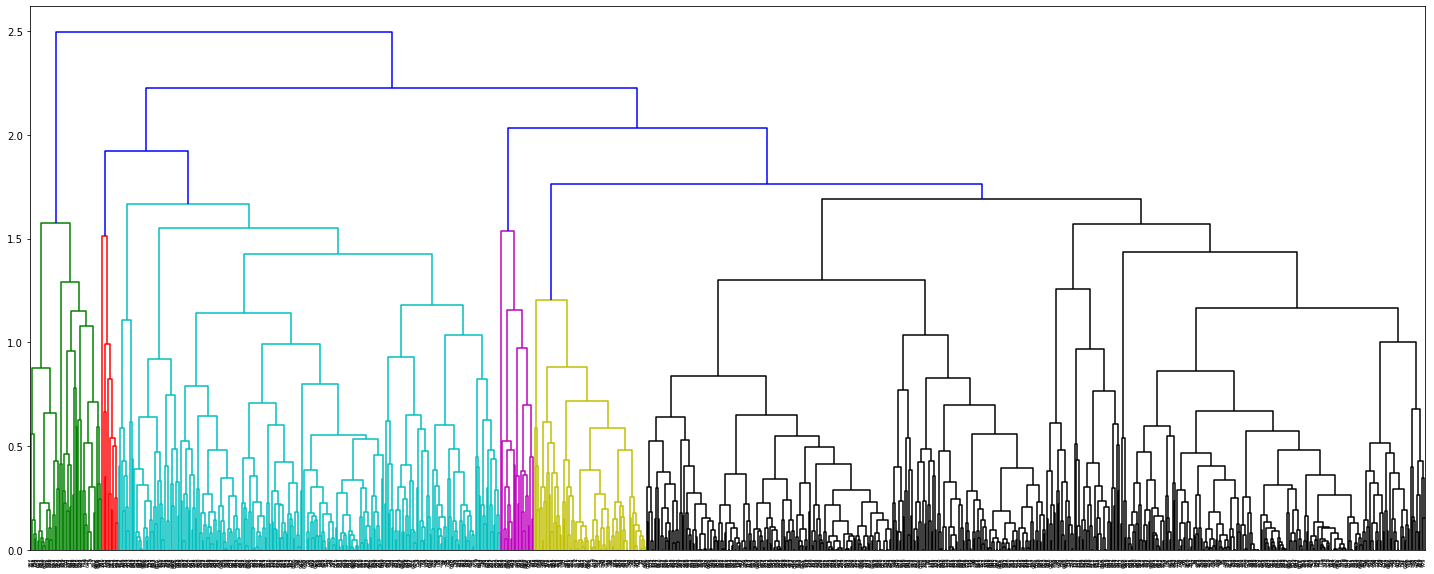

In [ ]:
# Dendogram
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
Z = linkage(data, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

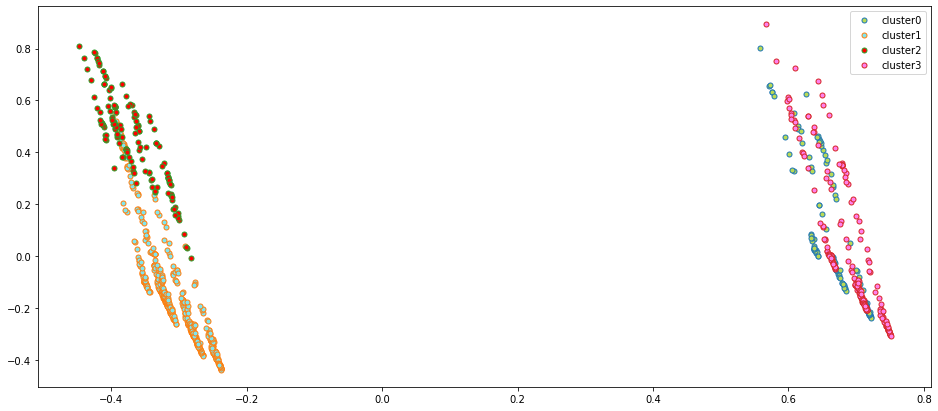

In [16]:
# Scatter plot
from sklearn.decomposition import PCA
data_visualize = pd.DataFrame(PCA(2).fit_transform(data), columns=['X','Y'])
cluster_coordinates = {}
for i in range(4):
  cluster_coordinates["cluster"+str(i)+"x"]=[]
  cluster_coordinates["cluster"+str(i)+"y"]=[]

for i in range(len(cluster_complete_index)):
  for j in range(len(cluster_complete_index[i])):
    cluster_coordinates["cluster"+str(i)+"x"].append(data_visualize['X'][cluster_complete_index[i][j]])
    cluster_coordinates["cluster"+str(i)+"y"].append(data_visualize['Y'][cluster_complete_index[i][j]])

marker_colors={0:'#bada55',1:'#7fe5f0',2:'#ff0000',3:'#ff80ed',4:'#696969'}
plt.figure(figsize=(16,7))
for i in range(4):
    plt.plot(cluster_coordinates["cluster"+str(i)+"x"],
             cluster_coordinates["cluster"+str(i)+"y"], 
             linestyle='None', marker='o', markersize=5, 
             markerfacecolor=marker_colors[i], label="cluster"+str(i))
    
plt.legend()
plt.show()